# Data Analysis and Modeling for Loan Defaults
The objective of this notebook is to explore the datasets provided for the assignment. Three categories of data was included are given below. Total number of users were 400.
1. **loan_outcomes** - Contains application_date and final loan outcome for all users.
2. **user_gps_fixes** - Contains gps_data points every time the customer opens the app. The data is comprised of geo-spatial attribtes such as lat, long, altitude, accuracy of data etc.
3. **user_attributes** - Contains user attributes such as age & income in last 30 days

**NO external datasets have been used. The jupyter notebook can be run sequentially provided all the import dependencies are met.**

The notebook is structured as given below. There are no distinct sections as such in the notebook. But small headings have been provided wherever necessary.
1. all the imports
2. conncetion to Postres DB
3. getting dataset into DF
4. analysing the data using multiple charts
5. Feature engineering for modeling
6. Acutal modeling - sklearn models created
7. Validation and testing model perfromance
8. Building an API to test on new data. The input data is formatted as JSON(or dict) for use over http.
9. Ideas and possible next steps if the dataset was large

In [326]:
#generic imports
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import seaborn as sns
import random
#modeling imports
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle

In [4]:
#create alchemy engine
postgres_url = 'postgresql+psycopg2://<user-name>:<password>@<host>/<db_name>'
alchemy_engine = create_engine(postgres_url, pool_recycle=3600)

In [5]:
#connect to postgres
db_connection = alchemy_engine.connect()

In [7]:
#read the data into pandas
loan_outcomes_df = pd.read_sql("select * from \"loan_outcomes\"", db_connection)
user_gps_fixes_df = pd.read_sql("select * from \"user_gps_fixes\"", db_connection)
user_attributes_df = pd.read_sql("select * from \"user_attributes\"", db_connection)

In [9]:
db_connection.close()

Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\nk862\.conda\envs\ml\lib\site-packages\sqlalchemy\pool\base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\nk862\.conda\envs\ml\lib\site-packages\sqlalchemy\pool\base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\nk862\.conda\envs\ml\lib\site-packages\sqlalchemy\engine\default.py", line 543, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



In [10]:
#get shapes
print("loan_outcomes_df shape", loan_outcomes_df.shape)
print("user_gps_fixes_df shape", user_gps_fixes_df.shape)
print("user_attributes_df shape", user_attributes_df.shape)

loan_outcomes_df shape (400, 3)
user_gps_fixes_df shape (26710, 9)
user_attributes_df shape (400, 3)


In [11]:
loan_outcomes_df.head()

,user_id,application_at,loan_outcome
0,1,2017-08-14 09:08:50.000000,defaulted
1,2,2016-05-17 10:10:12.447976,repaid
2,3,2016-10-20 10:07:20.459081,defaulted
3,4,2017-01-13 13:03:34.000000,defaulted
4,5,2016-11-03 15:41:39.124610,repaid


In [13]:
#check dtypes
loan_outcomes_df.dtypes

user_id                    int64
application_at    datetime64[ns]
loan_outcome              object
dtype: object

In [14]:
loan_outcomes_df['loan_outcome'].value_counts()

defaulted    200
repaid       200
Name: loan_outcome, dtype: int64

In [16]:
#check min-max of dates
print("application_dt min", loan_outcomes_df['application_at'].min())
print("application_dt max", loan_outcomes_df['application_at'].max())

application_dt min 2015-06-29 15:30:55
application_dt max 2018-12-19 11:42:23


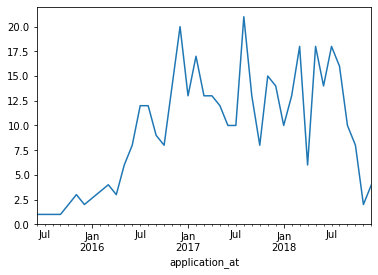

In [18]:
#number of loans booked by month
loan_outcomes_df.groupby(loan_outcomes_df['application_at'].dt.to_period("M")).size().plot()

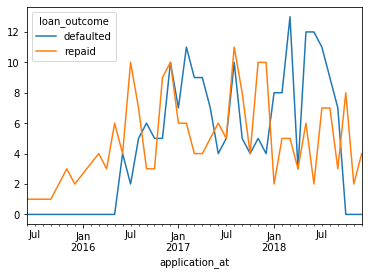

In [33]:
pd.pivot_table(loan_outcomes_df, index=loan_outcomes_df['application_at'].dt.to_period("M"), columns='loan_outcome', 
               values='user_id', aggfunc=lambda x: len(x.unique())).fillna(0).plot()

In [34]:
#explore user_gps_fixes
user_gps_fixes_df.head()

,gps_fix_at,server_upload_at,longitude,latitude,accuracy,altitude,bearing,location_provider,user_id
0,2017-06-22 09:37:20,2017-06-22 09:43:42,36.840540,-1.294342,68.4,0.0,0.0,fused,1
1,2017-08-14 07:50:27,2017-08-14 09:05:27,36.895270,-1.341928,1409.0,0.0,0.0,fused,1
2,2017-06-13 10:34:29,2017-06-13 10:54:48,36.811903,-1.307220,68.4,0.0,0.0,fused,1
3,2017-06-18 12:16:20,2017-06-18 12:16:24,36.907049,-1.309984,1581.0,0.0,0.0,fused,1
4,2017-06-28 09:39:08,2017-06-28 09:58:12,36.839396,-1.280310,1396.0,0.0,0.0,fused,1


In [35]:
user_gps_fixes_df.dtypes

gps_fix_at           datetime64[ns]
server_upload_at     datetime64[ns]
longitude                   float64
latitude                    float64
accuracy                    float64
altitude                    float64
bearing                     float64
location_provider            object
user_id                       int64
dtype: object

In [37]:
user_gps_fixes_df['user_id'].value_counts().head()

278    1615
30      619
100     494
162     416
223     398
Name: user_id, dtype: int64

In [38]:
user_gps_fixes_df['location_provider'].value_counts()

fused             23026
network            2792
gps                 871
local_database       21
Name: location_provider, dtype: int64

In [39]:
user_gps_fixes_df.describe()

,longitude,latitude,accuracy,altitude,bearing,user_id
count,26710.000000,26710.000000,2.671000e+04,26710.000000,26710.000000,26710.000000
mean,36.503743,-1.031422,1.006282e+03,332.259599,15.072191,194.645938
std,4.172315,1.850920,1.905380e+04,646.511986,57.378459,108.631662
min,-85.232791,-24.645763,-2.147463e+06,-161.700000,-1.000000,1.000000
25%,36.163351,-1.299535,2.050275e+01,0.000000,0.000000,103.000000
50%,36.825059,-1.232870,1.100000e+02,0.000000,0.000000,191.000000
75%,36.950463,-0.402338,2.200000e+03,0.000000,0.000000,278.000000
max,117.058355,56.242041,6.451553e+05,3012.900000,359.440000,400.000000


In [44]:
#check upload times
user_gps_fixes_df['upload_time_in_sec'] = (user_gps_fixes_df['server_upload_at'] - \
                                           user_gps_fixes_df['gps_fix_at']).dt.seconds

[]

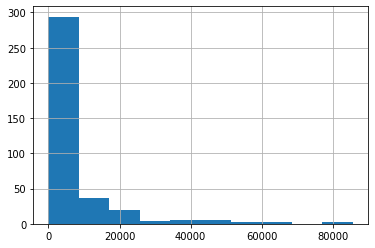

In [49]:
#plot default rate with upload time
upload_time_df = pd.merge(loan_outcomes_df[['user_id', 'loan_outcome']], 
                             user_gps_fixes_df.groupby('user_id').agg({'upload_time_in_sec': 'mean'}).reset_index(), 
                             how='left')
upload_time_df['upload_time_in_sec'].hist().plot()

In [52]:
upload_time_df['upload_time_group'] = pd.qcut(upload_time_df['upload_time_in_sec'], 10, labels=list(range(1,11)))

In [55]:
upload_time_df['is_default'] = upload_time_df['loan_outcome'].replace({'defaulted':1,'repaid':0})

In [53]:
upload_time_df.head()

,user_id,loan_outcome,upload_time_in_sec,upload_time_group
0,1,defaulted,999.100000,5
1,2,repaid,3810.100000,7
2,3,defaulted,12.000000,1
3,4,defaulted,73.500000,2
4,5,repaid,178.333333,3


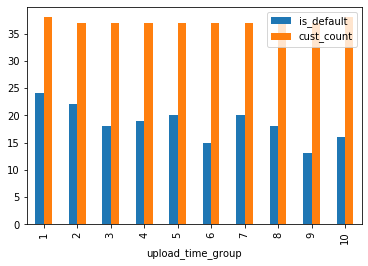

In [62]:
upload_time_df.groupby('upload_time_group').agg({'is_default':sum, 'upload_time_group':'count'}) \
    .rename(columns={'upload_time_group': 'cust_count'}).plot(kind='bar')

In [67]:
#check how the gps dates compare to application date
user_gps_fixes_df = pd.merge(user_gps_fixes_df, loan_outcomes_df[['user_id', 'application_at']], how='left')

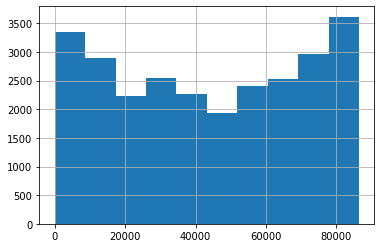

In [71]:
(user_gps_fixes_df['gps_fix_at'] - user_gps_fixes_df['application_at']).dt.seconds.hist()

the above graph indicates that all the gps data is after loan disbursement

In [74]:
default_dict = {'defaulted':1, 'repaid':0}

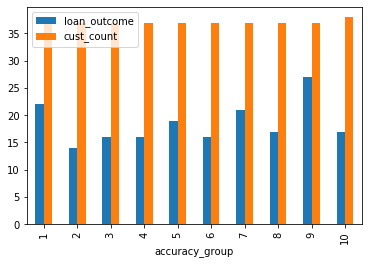

In [77]:
#plot default rate with average accuracy of location
accuracy_df = pd.merge(user_gps_fixes_df.groupby('user_id').agg({'accuracy':'mean'}).reset_index(), 
                         loan_outcomes_df[['user_id', 'loan_outcome']].replace(default_dict), how='left')
accuracy_df['accuracy_group'] = pd.qcut(accuracy_df['accuracy'], 10, labels=list(range(1,11)))
accuracy_df.groupby('accuracy_group').agg({'loan_outcome':sum, 'accuracy_group':'count'}) \
    .rename(columns={'accuracy_group': 'cust_count'}).plot(kind='bar')

customers with high accuracy default less

In [78]:
#explore user_attributes_df
user_attributes_df.head()

,user_id,age,cash_incoming_30days
0,1,42,8988.12
1,2,36,9968.12
2,3,27,59.04
3,4,38,2129.03
4,5,33,2102.53


In [80]:
user_attributes_df = pd.merge(user_attributes_df, loan_outcomes_df[['user_id', 'loan_outcome']].replace(default_dict))

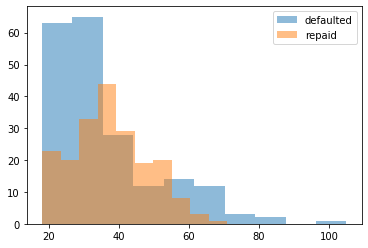

In [84]:
plt.hist(user_attributes_df[user_attributes_df['loan_outcome']==1]['age'], alpha=0.5, label='defaulted')
plt.hist(user_attributes_df[user_attributes_df['loan_outcome']==0]['age'], alpha=0.5, label='repaid')
plt.legend(loc='upper right')
plt.show()

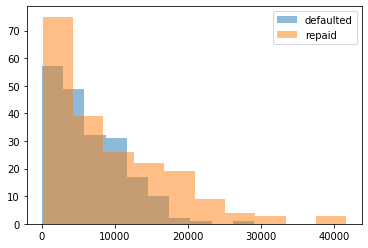

In [85]:
plt.hist(user_attributes_df[user_attributes_df['loan_outcome']==1]['cash_incoming_30days'], alpha=0.5, label='defaulted')
plt.hist(user_attributes_df[user_attributes_df['loan_outcome']==0]['cash_incoming_30days'], alpha=0.5, label='repaid')
plt.legend(loc='upper right')
plt.show()

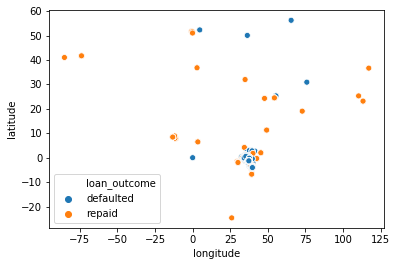

In [100]:
#check latitude longitude distribution
sns.scatterplot(data=pd.merge(user_gps_fixes_df, loan_outcomes_df[['user_id', 'loan_outcome']], how='left'), 
                x='longitude', y='latitude', hue='loan_outcome')

###### feature engineering

Mostly contains min, max, avg features across all the varaibles that are changing with time. But also includes other features by joining multiple dfs. Details are included in the comments with code.

In [86]:
loan_outcomes_df.head()

,user_id,application_at,loan_outcome
0,1,2017-08-14 09:08:50.000000,defaulted
1,2,2016-05-17 10:10:12.447976,repaid
2,3,2016-10-20 10:07:20.459081,defaulted
3,4,2017-01-13 13:03:34.000000,defaulted
4,5,2016-11-03 15:41:39.124610,repaid


In [87]:
features_df = loan_outcomes_df.copy()

In [89]:
features_df['loan_outcome'] = features_df['loan_outcome'].replace(default_dict)

In [94]:
features_df['month_of_application'] = features_df['application_at'].dt.month

In [96]:
features_df['hour_of_application'] = features_df['application_at'].dt.hour

In [104]:
#average latitude and longitude
features_df = pd.merge(features_df, user_gps_fixes_df.groupby('user_id').agg({'latitude': 'mean', 'longitude': 'mean'}) \
                       .reset_index().rename(columns={'latitude': 'mean_lat', 'longitude': 'mean_long'}), how='left')

In [109]:
#min max deviation from mean of lat/long
user_gps_fixes_df = pd.merge(user_gps_fixes_df, user_gps_fixes_df.groupby('user_id') \
                             .agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index() \
                             .rename(columns={'latitude': 'mean_lat', 'longitude': 'mean_long'}), how='left')

In [113]:
user_gps_fixes_df['sq_dist_from_mean'] = (user_gps_fixes_df['mean_lat'] - user_gps_fixes_df['latitude'])**2 + \
                                            (user_gps_fixes_df['mean_long'] - user_gps_fixes_df['longitude'])**2

In [126]:
df = user_gps_fixes_df.groupby('user_id').agg({'sq_dist_from_mean': [max, min]})
df.columns = df.columns.droplevel()
features_df = pd.merge(features_df, df.reset_index().rename(columns={'max': 'max_dist', 'min': 'min_dist'}), how='left')

In [134]:
#gps_fix_count - proxy for app opening
features_df = pd.merge(features_df, user_gps_fixes_df.groupby('user_id').size().reset_index(name='num_app_open'), how='left')

In [147]:
#min, max & mean for some columns
cols_for_features = ['upload_time_in_sec', 'altitude', 'accuracy', 'bearing']
col_metrics = ['min', 'max', 'mean']
df = user_gps_fixes_df.groupby('user_id').agg({key: col_metrics for key in cols_for_features})
df.columns = ["{}_{}".format(i,j) for i,j in df.columns]
features_df = pd.merge(features_df, df.reset_index(), how='left')

In [170]:
#location provider count and percentage of total count
df = user_gps_fixes_df.groupby(['user_id', 'location_provider']).size().reset_index(name='location_provider_count') \
        .pivot_table(index='user_id', columns='location_provider', values='location_provider_count').reset_index().fillna(0)
for col in user_gps_fixes_df['location_provider'].unique():
    df['{}_perc'.format(col)] = df[col]/df[user_gps_fixes_df['location_provider'].unique()].sum(axis=1)
#merge with features_df
features_df = pd.merge(features_df, df, how='left')

In [174]:
#drop application_at, get_dummies of month_of_application, group hour_of_application into 4
features_df = features_df.drop(columns=['application_at'])

In [180]:
features_df = pd.concat([features_df, pd.get_dummies(features_df['month_of_application'], prefix='month_of_application')], 
                        axis=1)

In [313]:
features_df['qcut_hour_group'], qcut_bins = pd.qcut(features_df['hour_of_application'], 4, labels=[i for i in range(1,5)], 
                                                    retbins=True)

In [314]:
features_df['equi_dist_hour_group'], cut_bins = pd.cut(features_df['hour_of_application'], 4, 
                                                       labels=[i for i in range(1,5)], retbins=True)

In [192]:
#merge age and cash income
features_df = pd.merge(features_df, user_attributes_df[['user_id', 'age', 'cash_incoming_30days']], how='left')

The idea is to build a seperate model for customers where gps data is not available. This model will only be built on non-gps data such as income, age and login date

#### Modeling

In [198]:
not_null_custs = features_df.dropna().reset_index(drop=True)

In [200]:
X = not_null_custs.drop(columns=['user_id', 'loan_outcome'])
Y = not_null_custs['loan_outcome']

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [202]:
y_train.value_counts()

0    149
1    148
Name: loan_outcome, dtype: int64

In [203]:
y_test.value_counts()

0    38
1    37
Name: loan_outcome, dtype: int64

In [205]:
#removing columns with zero variance
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)

VarianceThreshold(threshold=0.01)

In [209]:
model_columns = X_train.columns[constant_filter.get_support()]

In [212]:
print("Features with almost constant values removed: ", set(X_train.columns) - set(model_columns))

Features with almost constant values removed:  {'local_database', 'local_database_perc'}


In [216]:
#updating X_train
X_train = X_train[model_columns]

In [227]:
#removing correlated features
corr_matrix = not_null_custs.drop(columns=['user_id', 'local_database', 'local_database_perc', 'loan_outcome']).corr()

In [229]:
correlation_threshold = 0.75
corelated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j])>correlation_threshold:
            corelated_features.add(corr_matrix.columns[i])

In [235]:
#drop correlated_features
X_train = X_train.drop(columns=corelated_features)

This is just a simple classification model with no hyper-parameter tuning at all. The idea is to show the approach rather than high accuracy. With more data and actual scenario, something like cross-validation and hyper-parameter tuning using gridsearch or randomsearch. Also, since the data is less too much tuning would result in very small incremental gains.

In [252]:
clf = RandomForestClassifier(min_samples_split=0.1)

In [253]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

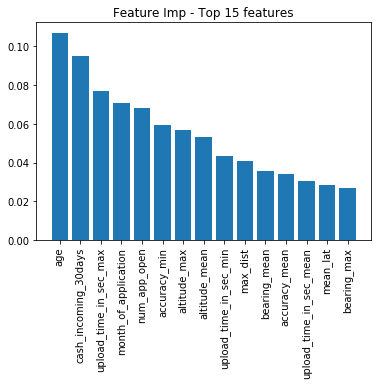

In [273]:
#feature importance
num_features = 15
plt.figure()
plt.title("Feature Imp - Top {} features".format(num_features))
plt.bar(X_train.columns[np.argsort(clf.feature_importances_)[::-1]][:num_features], 
        clf.feature_importances_[np.argsort(clf.feature_importances_)[::-1]][:num_features])
plt.xticks(rotation='vertical')
plt.show()

In [282]:
#building second model for customers where gps data is not available
X_train2, X_test2, y_train2, y_test2 = train_test_split(features_df[list(features_df.isna().sum() \
                        [features_df.isna().sum()==0].index)].drop(columns=['user_id', 'loan_outcome']), 
                        features_df['loan_outcome'], test_size=0.2, stratify=features_df['loan_outcome'])

In [283]:
y_train2.value_counts()

1    160
0    160
Name: loan_outcome, dtype: int64

In [284]:
y_test2.value_counts()

1    40
0    40
Name: loan_outcome, dtype: int64

In [288]:
correlation_threshold = 0.75
corelated_features = set()
corr_matrix = X_train2.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j])>correlation_threshold:
            corelated_features.add(corr_matrix.columns[i])

In [290]:
len(corelated_features) #no correlated features

0

In [297]:
clf2 = RandomForestClassifier(min_samples_split=0.15)

In [298]:
clf2.fit(X_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.15,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

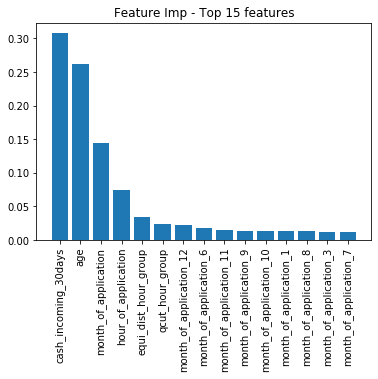

In [299]:
#feature importance
num_features = 15
plt.figure()
plt.title("Feature Imp - Top {} features".format(num_features))
plt.bar(X_train2.columns[np.argsort(clf2.feature_importances_)[::-1]][:num_features], 
        clf2.feature_importances_[np.argsort(clf2.feature_importances_)[::-1]][:num_features])
plt.xticks(rotation='vertical')
plt.show()

In [304]:
#save models
model_name_1 = 'model_1.sav'
model_name_2 = 'model_2.sav'
pickle.dump(clf, open(model_name_1, 'wb'))
pickle.dump(clf2, open(model_name_2, 'wb'))

#### Model's Performance

Performance is evaluated 2 ways:
    1. classifaction report which gives precision, recall and f1
    2. confusion matrix which indicates TP, TN, FP, FN

In [254]:
print("Training Data Results")
labels = ['repaid', 'defaulted']
print(classification_report(y_train, clf.predict(X_train), target_names=labels))

Training Data Results
              precision    recall  f1-score   support

      repaid       0.87      0.85      0.86       149
   defaulted       0.85      0.87      0.86       148

    accuracy                           0.86       297
   macro avg       0.86      0.86      0.86       297
weighted avg       0.86      0.86      0.86       297



In [255]:
print("Test Data Results")
print(classification_report(y_test, clf.predict(X_test[X_train.columns]), target_names=labels))

Test Data Results
              precision    recall  f1-score   support

      repaid       0.71      0.71      0.71        38
   defaulted       0.70      0.70      0.70        37

    accuracy                           0.71        75
   macro avg       0.71      0.71      0.71        75
weighted avg       0.71      0.71      0.71        75



In [259]:
print("Training confusion matrix")
print(confusion_matrix(y_train, clf.predict(X_train)))
print("Testing confusion matrix")
print(confusion_matrix(y_test, clf.predict(X_test[X_train.columns])))

Training confusion matrix
[[127  22]
 [ 19 129]]
Testing confusion matrix
[[27 11]
 [11 26]]


###### Model2 performance

In [300]:
print("Training Data Results")
print(classification_report(y_train2, clf2.predict(X_train2), target_names=labels))

Training Data Results
              precision    recall  f1-score   support

      repaid       0.80      0.76      0.78       160
   defaulted       0.77      0.81      0.79       160

    accuracy                           0.78       320
   macro avg       0.79      0.78      0.78       320
weighted avg       0.79      0.78      0.78       320



In [301]:
print("Test Data Results")
print(classification_report(y_test2, clf2.predict(X_test2[X_train2.columns]), target_names=labels))

Test Data Results
              precision    recall  f1-score   support

      repaid       0.59      0.50      0.54        40
   defaulted       0.57      0.65      0.60        40

    accuracy                           0.57        80
   macro avg       0.58      0.57      0.57        80
weighted avg       0.58      0.57      0.57        80



In [302]:
print("Training confusion matrix")
print(confusion_matrix(y_train2, clf2.predict(X_train2)))
print("Testing confusion matrix")
print(confusion_matrix(y_test2, clf2.predict(X_test2)))

Training confusion matrix
[[121  39]
 [ 30 130]]
Testing confusion matrix
[[20 20]
 [14 26]]


#### API

The objective here is to create an API that can be converted to a REST API. The below class needs to be instantiated with a http server and that's it. The `score` function in the class handles all the feature engineering required to score the customer.

In [410]:
#create a class to run model and other functions
class RunModel(object):
    def __init__(self, model_1_filename, model_2_filename, model_1_cols, model_2_cols, qcut_hour_bins, cut_hour_bins, 
                 qcut_hour_labels, cut_hour_labels):
        self.model_1 = pickle.load(open(model_1_filename, 'rb'))
        self.model_2 = pickle.load(open(model_2_filename, 'rb'))
        self.qcut_hour_bins = qcut_hour_bins
        self.cut_hour_bins = cut_hour_bins
        self.qcut_hour_labels = qcut_hour_labels
        self.cut_hour_labels = cut_hour_labels
        self.model_1_cols = model_1_cols
        self.model_2_cols = model_2_cols
    
    def is_gps_data_preset(self, data):
        #for now this will be a simple check to count the number of records in user_gps_fixes
        if 'user_gps_fixes' in data:
            return True
        return False
    
    def get_application_features(self, application_dt):
        result_dict = {}
        result_dict['month_of_application'] = application_dt.month
        result_dict['hour_of_application'] = application_dt.hour
        for i in range(1,13):
            result_dict['month_of_application_{}'.format(i)] = 1 if i==application_dt.month else 0
        result_dict['qcut_hour_group'] = pd.cut([application_dt.hour], bins=self.qcut_hour_bins, 
                                                labels=self.qcut_hour_labels, include_lowest=True)
        result_dict['equi_dist_hour_group'] = pd.cut([application_dt.hour], bins=self.cut_hour_bins, 
                                                labels=self.cut_hour_labels, include_lowest=True)
        return result_dict
    
    def get_gps_fix_features(self, gps_fix_data):
        gps_fix_data_df = pd.DataFrame(gps_fix_data)
        #create result_dict
        result_dict = {}
        result_dict['mean_lat'] = gps_fix_data_df['latitude'].mean()
        result_dict['mean_long'] = gps_fix_data_df['longitude'].mean()
        
        #create req. features
        gps_fix_data_df['dist'] = (gps_fix_data_df['latitude'] - result_dict['mean_lat'])**2 + \
                                    (gps_fix_data_df['longitude'] - result_dict['mean_long'])**2
        gps_fix_data_df['upload_time'] = (gps_fix_data_df['server_upload_at'] - gps_fix_data_df['gps_fix_at']).dt.seconds
                
        result_dict['max_dist'] = gps_fix_data_df['dist'].max()
        result_dict['num_app_open'] = len(gps_fix_data)
        result_dict['upload_time_in_sec_min'] = gps_fix_data_df['upload_time'].min()
        result_dict['upload_time_in_sec_mean'] = gps_fix_data_df['upload_time'].mean()
        result_dict['upload_time_in_sec_max'] = gps_fix_data_df['upload_time'].max()
        result_dict['altitude_min'] = gps_fix_data_df['altitude'].min()
        result_dict['altitude_max'] = gps_fix_data_df['altitude'].max()
        result_dict['altitude_mean'] = gps_fix_data_df['altitude'].mean()
        result_dict['accuracy_min'] = gps_fix_data_df['accuracy'].min()
        result_dict['accuracy_mean'] = gps_fix_data_df['accuracy'].mean()
        result_dict['bearing_min'] = gps_fix_data_df['bearing'].min()
        result_dict['bearing_max'] = gps_fix_data_df['bearing'].max()
        result_dict['bearing_mean'] = gps_fix_data_df['bearing'].mean()
        result_dict['gps'] = gps_fix_data_df[gps_fix_data_df['location_provider']=='gps'].shape[0]
        result_dict['network'] = gps_fix_data_df[gps_fix_data_df['location_provider']=='network'].shape[0]
        result_dict['fused_perc'] = gps_fix_data_df[gps_fix_data_df['location_provider']=='fused'].shape[0]/ \
                                        result_dict['num_app_open']
        result_dict['gps_perc'] = gps_fix_data_df[gps_fix_data_df['location_provider']=='gps'].shape[0]/ \
                                        result_dict['num_app_open']
        return result_dict
    
    def get_user_attributes_features(self, user_attributes_data):
        return {'age': user_attributes_data['age'], 'cash_incoming_30days': user_attributes_data['cash_incoming_30days']}
    
    def create_gps_features(self, single_cust_data):
        #create features in the same order as req. by model_1
        application_features = self.get_application_features(single_cust_data['application_dt'])
        gps_fix_features = self.get_gps_fix_features(single_cust_data['user_gps_fixes'])
        user_attributes_features = self.get_user_attributes_features(single_cust_data['user_attributes'])
        #code to merge basis model features
        merged_features = pd.DataFrame({**application_features, **gps_fix_features, **user_attributes_features}) \
                            [self.model_1_cols]
        return merged_features.to_numpy()
    
    def create_application_features(self, single_cust_data):
        #create features in the same order as req. by model_2
        application_features = self.get_application_features(single_cust_data['application_dt'])
        user_attributes_features = self.get_user_attributes_features(single_cust_data['user_attributes'])
        #code to merge basis model features
        merged_features = pd.DataFrame({**application_features, **user_attributes_features})[self.model_2_cols]
        return merged_features.to_numpy()
    
    def score(self, single_cust_data):
        #here we're assuming that single_cust_data is a dictionary of the same form as the tables used for training
        #sample : {'application_dt': 2017-08-14 09:08:50.000000, 
        # 'user_gps_fixes': [list of dict values of all columns as in DB, except user_id], 
        # 'user_attributes': {'age': 40, 'cash_incoming_30days': 10000}}. Therefore no validation on input_data has been 
        #coded here. In production however, this would not be the case.
        if self.is_gps_data_preset(single_cust_data):
            features = self.create_gps_features(single_cust_data)
            result = self.model_1.predict(features)
        else:
            features = self.create_application_features(single_cust_data)
            result = self.model_2.predict(features)
        return {"will_default": 1} if result else {"will_default": 0}

In [411]:
#create object of class
run_model = RunModel(model_1_filename=model_name_1, model_2_filename=model_name_2, model_1_cols=X_train.columns, 
                     model_2_cols=X_train2.columns, qcut_hour_bins=qcut_bins, cut_hour_bins=cut_bins, 
                     qcut_hour_labels=list(range(1,5)), cut_hour_labels=list(range(1,5)))

In [412]:
def get_data_for_user_in_dict(user_id, return_gps_data=True):
    input_data = {}
    input_data['application_dt'] = loan_outcomes_df[loan_outcomes_df['user_id']==random_user]['application_at'].iloc[0]
    if return_gps_data:
        input_data['user_gps_fixes'] = user_gps_fixes_df[user_gps_fixes_df['user_id']==random_user][['gps_fix_at', 
                                            'server_upload_at', 'longitude', 'latitude', 'accuracy', 'altitude', 'bearing', 
                                            'location_provider']].to_dict('records')
    input_data['user_attributes'] = user_attributes_df[user_attributes_df['user_id']==random_user][['age', 
                                    'cash_incoming_30days']].to_dict('records')[0]
    return input_data

In [413]:
#create a sample dictionary as input
random_user = random.choice(user_gps_fixes_df['user_id'].unique())
input_data_with_gps = get_data_for_user_in_dict(random_user)
input_data_wo_gps = get_data_for_user_in_dict(random_user, return_gps_data=False)

In [414]:
print("With GPS output", run_model.score(input_data_with_gps))
print("Without GPS output", run_model.score(input_data_wo_gps))

With GPS output {'will_default': 1}
Without GPS output {'will_default': 1}


The above result indicates that this customer will default. Although I have put both results i.e. with GPS data and w/o GPS data, ideally one customer will fall into only one category. The above example is just for respresentation purposes to show how the API handles both.

#### Ideas if this was a large dataset with more users
1. A sequence classifier could be tried as the gps data is a sequence of events. For eg. some kind of RNN
2. Some automated time series feature engineering could be done
3. Ensemble ML methods could be tried
4. A lot more attributes could maybe give rise to distinct clusters in the data, for which different models could be built
5. Using external dataset related to longitudes and latitudes could be used to create geogrphical attributes such as distance to city center, household population in vicinity, per capita income in that area etc.